In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
cos_sim_df = pd.read_parquet(
    "../07.compute-cosine-similarities/cos_sim/cosine_similarities_genes_orf-all.parquet"
)

cos_sim_df.head()

CDK9    ZNF597      CDX1  LUCIFERASE      SIX2      HSF5  \
CDK9        1.000000 -0.053557 -0.036738    0.185173  0.053934 -0.033102   
ZNF597     -0.053557  1.000000  0.069338    0.094281  0.036989  0.180690   
CDX1       -0.036738  0.069338  1.000000    0.053382  0.170138  0.124885   
LUCIFERASE  0.185173  0.094281  0.053382    1.000000  0.099741  0.133293   
SIX2        0.053934  0.036989  0.170138    0.099741  1.000000  0.153347   

                ATF7     DIDO1      RAI1     HcRed  ...      HPGD   HSD17B3  \
CDK9       -0.020880  0.024192  0.102774  0.188763  ...  0.040449 -0.018367   
ZNF597      0.047083  0.095729  0.081758  0.062295  ...  0.021428  0.064239   
CDX1        0.115133  0.055702  0.083784  0.109262  ...  0.010269  0.047989   
LUCIFERASE  0.148306  0.182818  0.190666  0.607766  ...  0.184806 -0.034328   
SIX2        0.068425  0.043138  0.097845  0.108223  ...  0.035675 -0.172400   

               RAB32   SLC39A9       TNF     OSER1     MRAP2    DNAAF6  \
CDK9        0.028402  0.047726  0.065281 -0.056427  0.048590  0.094420   
ZNF597      0.004501  0.066912 -0.142149 -0.046353  0.065912 -0.042277   
CDX1       -0.032858 -0.011991 -0.041313  0.021274  0.022880  0.103896   
LUCIFERASE  0.200412  0.107746  0.003294  0.048373  0.169493  0.122674   
SIX2       -0.060922  0.094394 -0.016155 -0.021136  0.007049  0.093166   

                LY6D      COQ4  
CDK9       -0.014681  0.003006  
ZNF597      0.068089 -0.004047  
CDX1        0.169554  0.061498  
LUCIFERASE  0.071305  0.122501  
SIX2        0.078007  0.002403  

[5 rows x 12602 columns]

In [3]:
chromosome_df = pd.read_csv(
    "../00.download-and-process-annotations/output/gene_chromosome_location_processed.tsv",
    sep="\t", usecols=["Approved_symbol", "Chromosome_number", "Arm_name"]
)

chromosome_df.replace({"Chromosome_number": {"X": 23, "Y": 24}}, inplace=True)

chromosome_df["Chromosome_number"] = chromosome_df["Chromosome_number"].astype(int)

chromosome_df = (
    chromosome_df.assign(Chromosome_arm=lambda x: x.apply(lambda y: f'{y.Chromosome_number:02}{y.Arm_name}', axis=1)) # Add leading zero
)

chromosome_df.head()

Approved_symbol  Chromosome_number Arm_name Chromosome_arm
0            A1BG                 19        q            19q
1        A1BG-AS1                 19        q            19q
2            A1CF                 10        q            10q
3             A2M                 12        p            12p
4         A2M-AS1                 12        p            12p

In [4]:
genes_df = pd.DataFrame(
    {"Approved_symbol": cos_sim_df.columns},
    index=[i for i in range(len(cos_sim_df.columns))],
)

genes_df = genes_df.merge(chromosome_df, how="inner", on="Approved_symbol")

genes_df = genes_df.sort_values(by=["Chromosome_number", "Arm_name"]).reset_index(drop=True)

genes_df.head()

Approved_symbol  Chromosome_number Arm_name Chromosome_arm
0           GMEB1                  1        p            01p
1           SCMH1                  1        p            01p
2             DR1                  1        p            01p
3           HMGN2                  1        p            01p
4            RCC1                  1        p            01p

In [5]:
# Compute borderline index when chromosome number changes
chrom_group = genes_df.groupby('Chromosome_number').groups
chrom_idx = []
for gp in chrom_group:
    chrom_idx.append(chrom_group[gp][0])
chrom_idx.sort()

# Compute borderline index when chromosome arm changes
locus_group = genes_df.groupby('Chromosome_arm').groups
arm_idx = []
for gp in locus_group:
    idx = locus_group[gp][0]
    if idx not in chrom_idx:
        arm_idx.append(idx)
arm_idx.sort()

In [6]:
genes = genes_df.Approved_symbol.to_list()

cos_sim_df = cos_sim_df.loc[genes, genes]

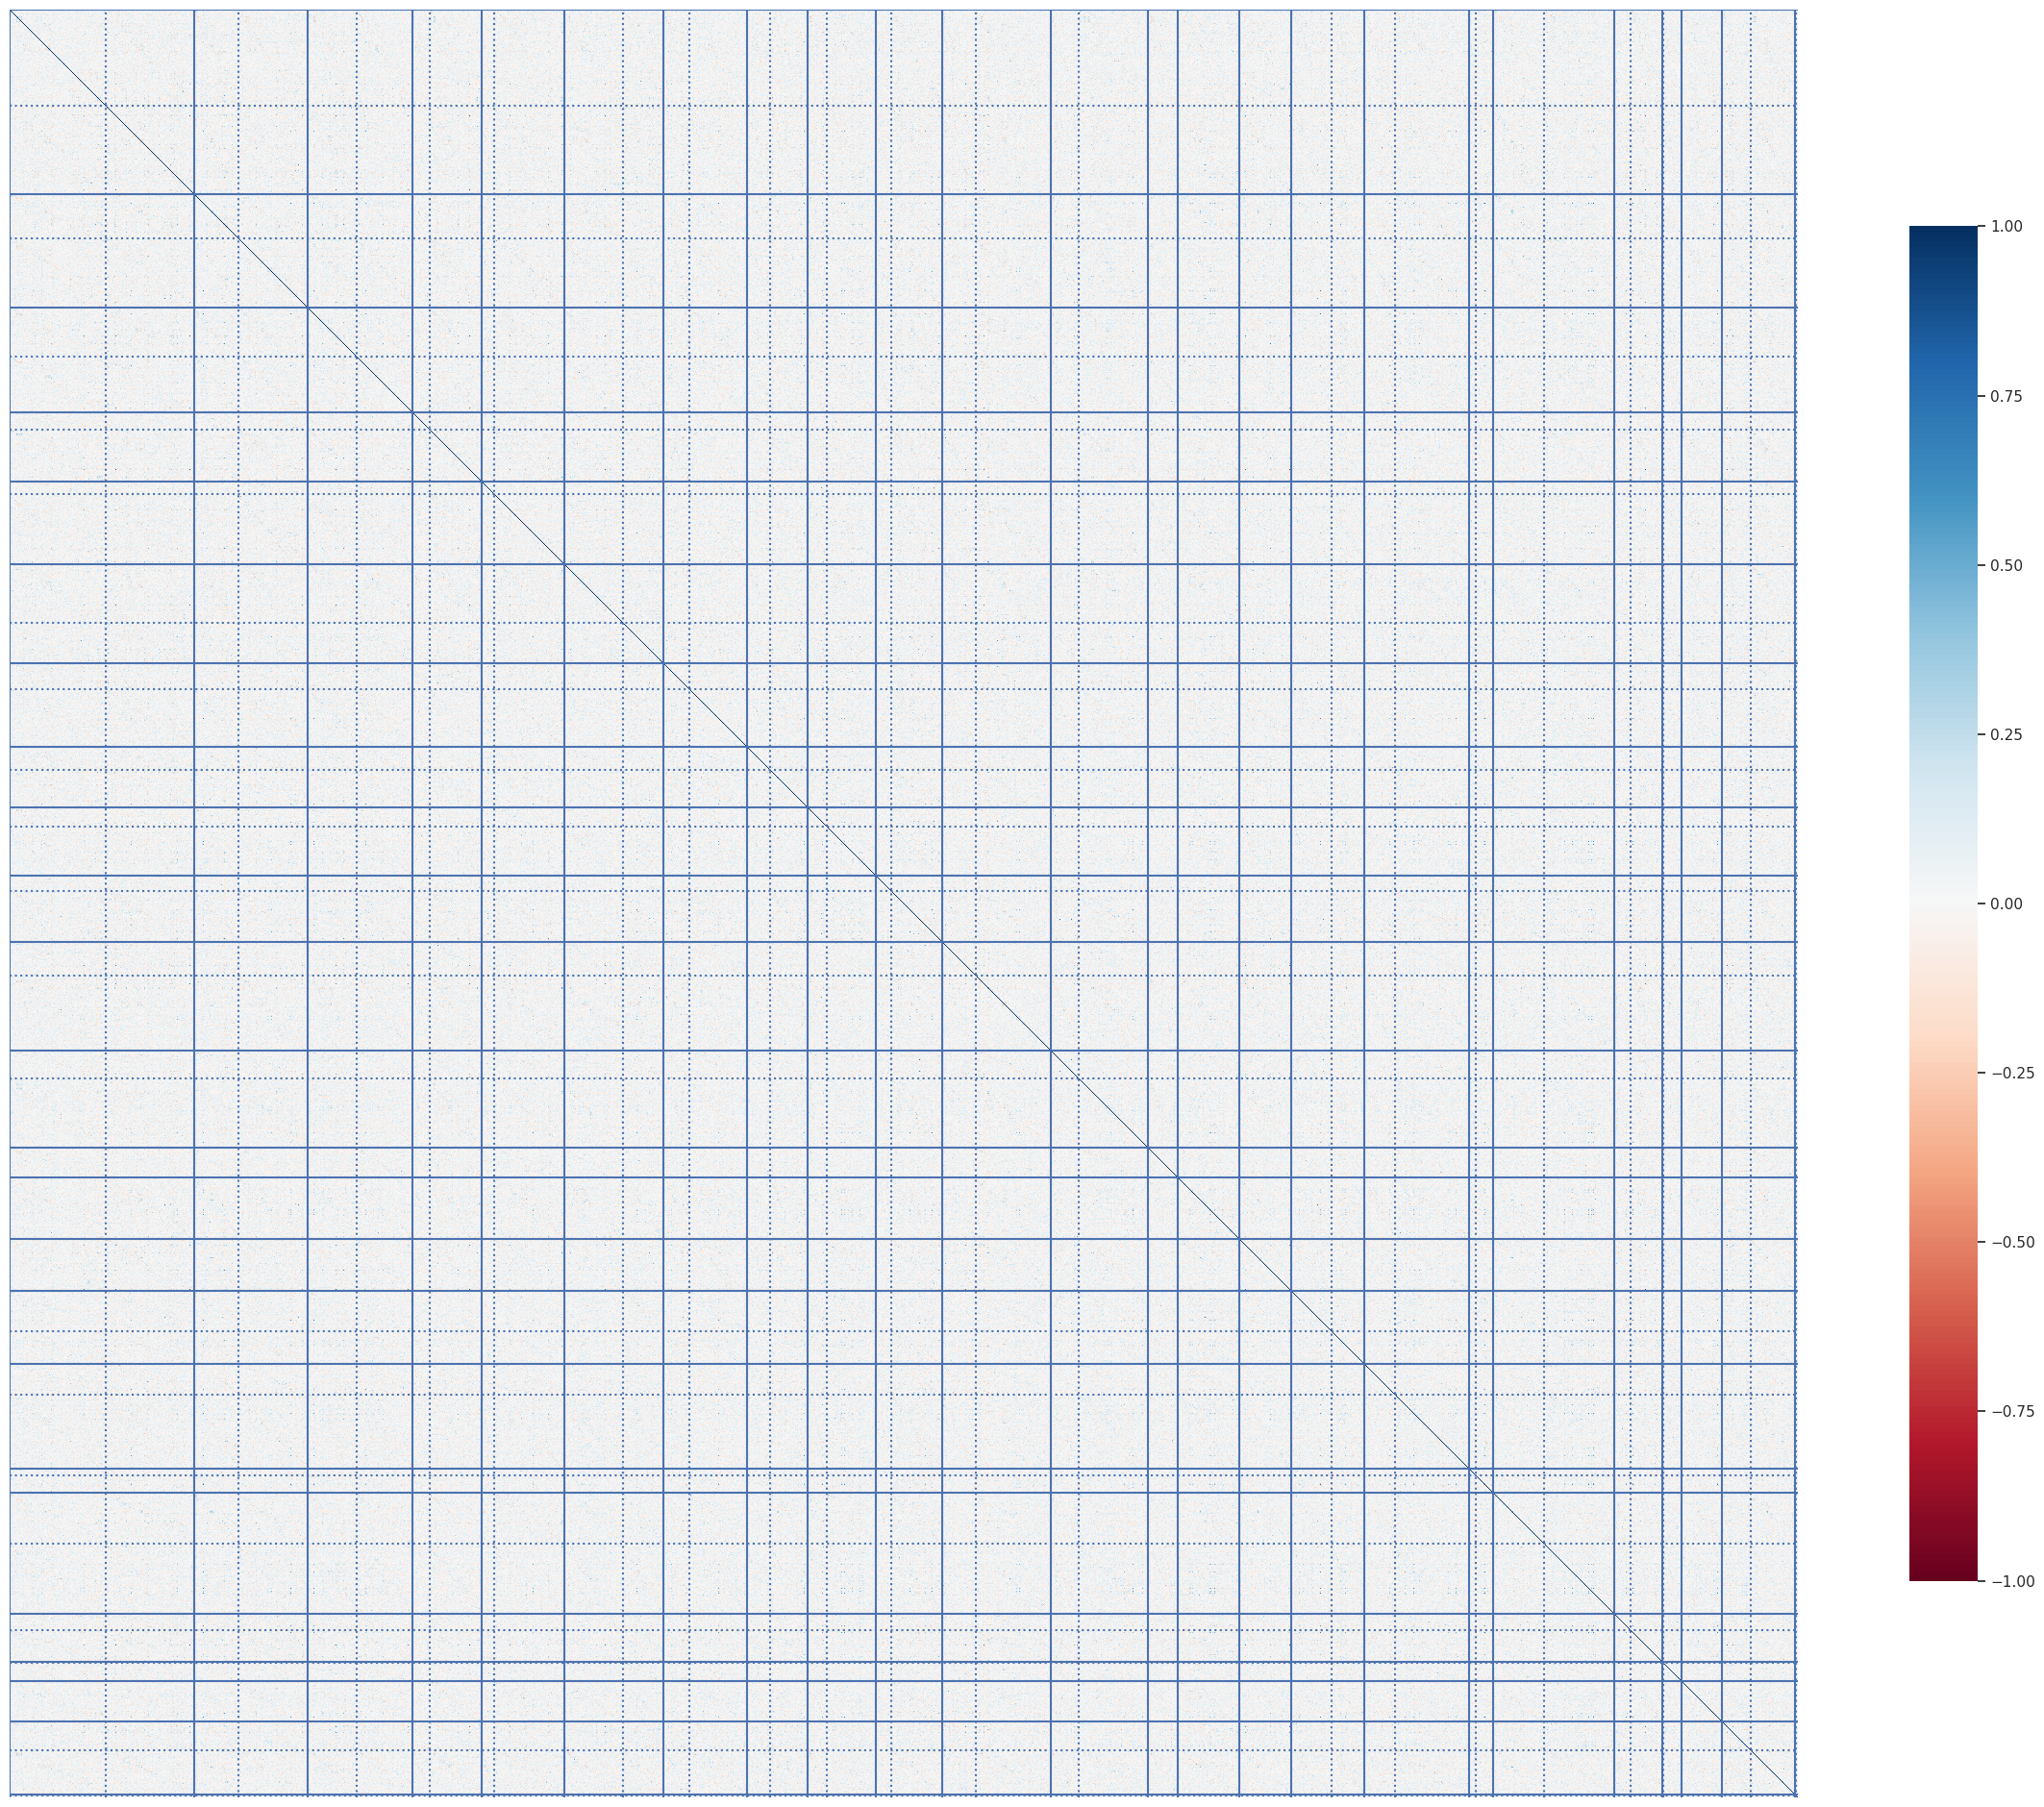

In [7]:
sns.set(rc={"figure.figsize": (30, 30)})

ax = sns.heatmap(
    cos_sim_df,
    cmap="RdBu",
    square=True,
    vmin=-1, 
    vmax=1,
    xticklabels=False,
    yticklabels=False,
    cbar_kws={"shrink": 0.61},
)

ax.hlines(chrom_idx, *ax.get_xlim())
ax.hlines(arm_idx, linestyles='dotted', *ax.get_xlim())
ax.vlines(chrom_idx, *ax.get_ylim())
ax.vlines(arm_idx, linestyles='dotted', *ax.get_ylim())

plt.savefig("figures/orf-chromosome-arm-similarity.png", dpi=300)
